# Training data: color

While we describe colors in terms of hue (the color wheel), saturation (color intensity), and value (brightness), RGB values combine these properties in a non-intuitive way.

Primary colors are fully-saturated, and are vectors of length 1:

| Color |  R  |  G  |  B  | Length |
| ----- | :-: | :-: | :-: | :----: |
| red   | $1$ | $0$ | $0$ |  $1$   |
| green | $0$ | $1$ | $0$ |  $1$   |
| blue  | $1$ | $0$ | $1$ |  $1$   |

Secondary colors are also fully-saturated, but have length $\sqrt2$:

| Color   |  R  |  G  |  B  |  Length  |
| ------- | :-: | :-: | :-: | :------: |
| yellow  | $1$ | $1$ | $0$ | $\sqrt2$ |
| cyan    | $0$ | $1$ | $1$ | $\sqrt2$ |
| magenta | $0$ | $0$ | $1$ | $\sqrt2$ |

Whereas grayscale values are fully _desaturated_ (have no defined hue), and have various lengths:

| Color |     R      |     G      |     B      |  Length  |
| ----- | :--------: | :--------: | :--------: | :------: |
| black |    $0$     |    $0$     |    $0$     |   $0$    |
| gray  | $\sqrt{⅓}$ | $\sqrt{⅓}$ | $\sqrt{⅓}$ |   $1$    |
| white |    $1$     |    $1$     |    $1$     | $\sqrt3$ |

We could pick random RGB values, but even if the vectors were normalized, we wouldn't necessarily get data that compresses well to a 2D embedding. So we will use `colorsys` — a builtin Python module that lets us work with perceptual properties. For our superposition experiment, generating colors by varying hue while keeping saturation and value fixed gives us a much more intuitive and evenly distributed set of training examples that isolate the property we're most interested in studying.

Let's do a quick test to see if we can reproduce the primary and secondary RGB values just by varying the hue.


In [1]:
import colorsys
import numpy as np

# Create an array of evenly spaced hues (every 60 degrees)
hues = np.arange(0, 360, 60, dtype=float)

# Convert each HSV value to RGB
rgb_colors = np.array([(h,) + colorsys.hsv_to_rgb(h / 360, 1, 1) for h in hues])

print(rgb_colors)

[[  0.   1.   0.   0.]
 [ 60.   1.   1.   0.]
 [120.   0.   1.   0.]
 [180.   0.   1.   1.]
 [240.   0.   0.   1.]
 [300.   1.   0.   1.]]


That looks about right. We'll visualize it below.

## Color cubes & train / test splits

We're going to want various ways to hold out data for validation and testing. Naively, we could randomly hold out some fraction of colors from a long list. But there's structure in the data, and our train/test split should be based on that — or we can't tell whether the model is generalizing well.

Suppose we create a dataset based on HSV, and we're interested in training a model that generalizes to unseen hues. Then, we would like to be able to exclude a specific band of hues from the training set, but include it in the test set. E.g. we might train on all colors except those that are close to cyan.

We'll need some utilities for this. For now, let's assume we'll train the model on RGB values. We will define a _color cube_ to contain a block of RGB values, indexed by some color space, e.g. HSV. The grid should therefore have dimensions like `(H, S, V, C)` or `(R, G, B, C)`, where `C` contains the RGB values of each cell as a vector of length 3.

The nice thing about this is that when we construct the cube, we can omit parts of the coordinate space. For example, we could use hues ranging from 0..150° and 210..360° — which would exclude cyan.

In [4]:
import numpy as np


class ColorCube:
    def __init__(self, rgb_grid: np.ndarray, coordinates: tuple[np.ndarray, ...], space: str, canonical_space: str):
        self.space = space
        self.canonical_space = canonical_space
        self.coordinates = coordinates
        self.rgb_grid = rgb_grid

    @classmethod
    def from_hsv(cls, h: np.ndarray, s: np.ndarray, v: np.ndarray):
        import skimage as ski
        grid = ski.color.hsv2rgb(coordinate_grid(h, s, v))
        return cls(grid, (h, s, v), 'hsv', 'hsv')

    @classmethod
    def from_rgb(cls, r: np.ndarray, g: np.ndarray, b: np.ndarray):
        grid = coordinate_grid(r, g, b)
        return cls(grid, (r, g, b), 'rgb', 'rgb')

    def permute(self, new_space: str):
        if set(self.space) != set(new_space):
            raise ValueError(f'Cannot permute {self.space} to {new_space}: different axes')
        indices = tuple(self.space.index(axis) for axis in new_space)
        new_grid = np.transpose(self.rgb_grid, indices + (-1,))
        new_coordinates = tuple(self.coordinates[i] for i in indices)
        return ColorCube(new_grid, new_coordinates, new_space, self.canonical_space)


def coordinate_grid(*coordinates: list | np.ndarray) -> np.ndarray:
    """
    Create a coordinate grid for n-dimensional space.

    Parameters
        `coordinates`: List of 1D arrays representing the coordinates along each axis.

    Returns
        An n+1D array where the last dimension contains the indices for each coordinate.
    """
    # Create meshgrid
    grids = np.meshgrid(*coordinates, indexing='ij')

    # Stack along a new last dimension
    return np.stack(grids, axis=-1)

Let's also define a function to visualize a color cube. We'll draw one subplot per slice of the primary axis (e.g. split by hue).

In [24]:
def plot_colors(cube: ColorCube, pretty: bool | str = True, patch_size: float = 0.25, title: str = ''):
    from math import ceil
    import matplotlib.pyplot as plt
    from itertools import chain

    if pretty is True:
        pretty = cube.space
    elif pretty is False:
        pretty = ''

    def fmt(axis: str, v: float | int) -> str:
        if axis in pretty:
            return prettify(float(v))
        else:
            return f'{v:.2g}'

    # Create a figure with subplots

    main_axis, y_axis, x_axis = cube.space
    main_coords, y_coords, x_coords = cube.coordinates

    n_plots = len(main_coords)
    nominal_width = 70
    full_width = len(x_coords) * n_plots + (n_plots - 1)
    n_rows = ceil(full_width / nominal_width)
    n_cols = ceil(n_plots / n_rows)

    # Calculate appropriate figure size based on data dimensions
    # Base size per subplot, adjusted by the data dimensions
    subplot_width = patch_size * len(x_coords)
    subplot_height = patch_size * len(y_coords) + 0.5

    # Calculate total figure size with some margins between plots
    figsize = (n_cols * subplot_width, n_rows * subplot_height)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=figsize,
        sharex=True,
        sharey=True,
        squeeze=False,
    )
    axes = list(chain(*axes))  # Flatten the axes array

    # Plot each slice of the cube (one for each value)
    for i, ax in enumerate(axes):
        if i >= len(main_coords):
            ax.set_visible(False)
            continue
        row = i // n_cols
        col = i % n_cols

        ax.imshow(cube.rgb_grid[i])

        ax.set_title(f'{main_axis} = {fmt(main_axis, main_coords[i])}', fontsize=8)

        # Add axes labels without cluttering the display
        if row == n_rows - 1:
            ax.xaxis.set_ticks([0, len(x_coords) - 1])
            coord1 = fmt(x_axis, x_coords[0])
            coord2 = fmt(x_axis, x_coords[-1])
            ax.xaxis.set_ticklabels([coord1, coord2])
            ax.xaxis.set_tick_params(labelsize=8)
            ax.set_xlabel(x_axis.upper(), fontsize=8)
        else:
            ax.xaxis.set_visible(False)

        if col == 0:
            ax.yaxis.set_ticks([0, len(y_coords) - 1])
            coord1 = fmt(y_axis, y_coords[0])
            coord2 = fmt(y_axis, y_coords[-1])
            ax.yaxis.set_ticklabels([coord1, coord2])
            ax.yaxis.set_tick_params(labelsize=8)
            ax.set_ylabel(y_axis.upper(), fontsize=8)
        else:
            ax.yaxis.set_visible(False)

    _title = f'{title} - ' if title else ''
    plt.suptitle(
        f'{_title}{cube.canonical_space.upper()} as {x_axis.upper()},{y_axis.upper()} per {main_axis.upper()}',
        color='gray',
    )

    # Light and dark mode compatibility = compromise on both!
    fig.patch.set_alpha(0)
    for ax in axes:
        ax.patch.set_alpha(0)
        ax.title.set_color('gray')
        ax.xaxis.label.set_color('gray')
        ax.yaxis.label.set_color('gray')
        ax.tick_params(colors='gray')

    plt.show()


def prettify(value: float, tolerance=1e-10):
    """Convert a float to a string, attempting to make it more human-readable."""
    from sympy import nsimplify, pretty

    # result = fu(value)
    result = nsimplify(value, tolerance=tolerance, rational_conversion='exact')
    s = pretty(result, use_unicode=True)
    if '\n' in s:
        return str(result)
    else:
        return s

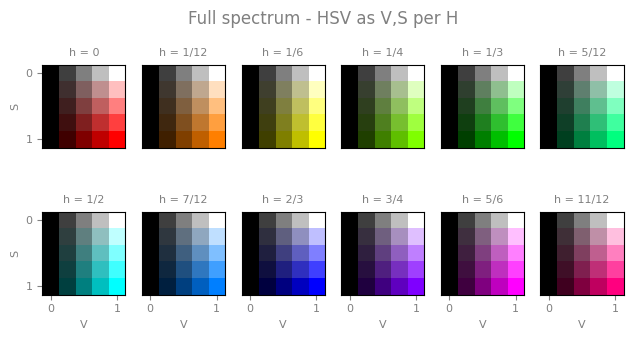

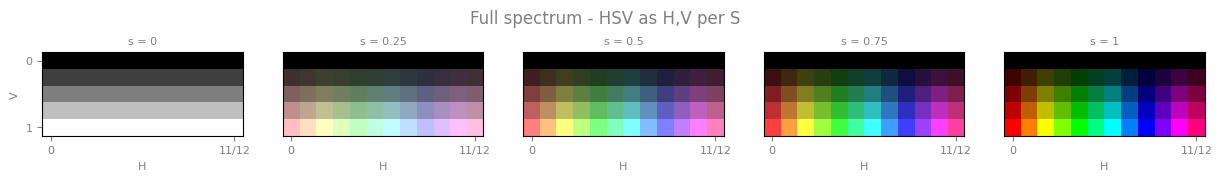

In [26]:

# Example usage: HSV
hsv_cube = ColorCube.from_hsv(
    np.arange(0, 1, 1 / 12),  # A full spectrum of hues, 12 steps yields primary, secondary, and tertiary colors
    np.linspace(0, 1, 5),  # Saturation from 0 (greyscale) to 1 (full color)
    np.linspace(0, 1, 5),  # Value from 0 (black) to 1 (full brightness)
)

# Plot the colors in the HSV cube, with one subplot per hue
plot_colors(hsv_cube, title='Full spectrum')

# Reorder the axes to draw one subplot per saturation value
plot_colors(hsv_cube.permute('svh'), 'h', title='Full spectrum')

That seems to do what we would expect: 12 hues, 5 saturations, and 5 values. How about an RGB cube?

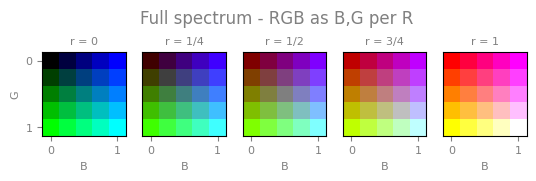

In [28]:
# Example usage: RGB
rgb_cube = ColorCube.from_rgb(
    np.linspace(0, 1, 5),  # Red from 0 to 1
    np.linspace(0, 1, 5),  # Green from 0 to 1
    np.linspace(0, 1, 5),  # Blue from 0 to 1
)
plot_colors(rgb_cube, title='Full spectrum')


Let's check that we can create a cube with missing slices. Because the cube is constructed using Numpy arrays as coordinate axes, we can use Numpy operations to filter an axis before construction. Hue needs special consideration, because it's cyclic.

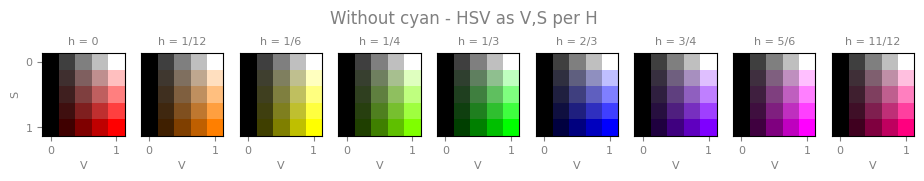

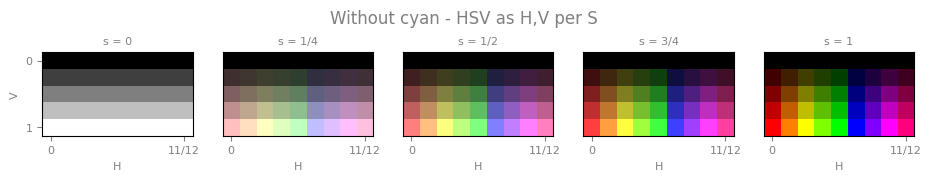

In [30]:
cyan = 3/6

all_hues = np.arange(0, 1, 1/12)
# Hold out the hue that is closest to cyan. Use a large tolerance to capture all hues that are close to cyan.
holdout = np.isclose(all_hues, cyan, atol=1/12 + 1e-8)

hsv_cube = ColorCube.from_hsv(
    all_hues[~holdout],
    np.linspace(0, 1, 5),
    np.linspace(0, 1, 5),
)

plot_colors(hsv_cube, title='Without cyan')
plot_colors(hsv_cube.permute('svh'), title='Without cyan')

Indeed, we were able to create a cube covering the full spectrum _except_ for colors within 30° of cyan (three hue bands). However, for colors close to red, we'll need to account for the cyclic nature of the hue dimension.

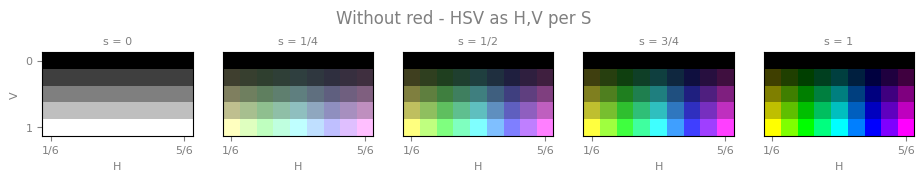

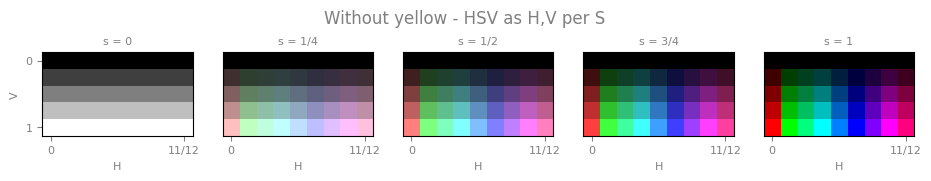

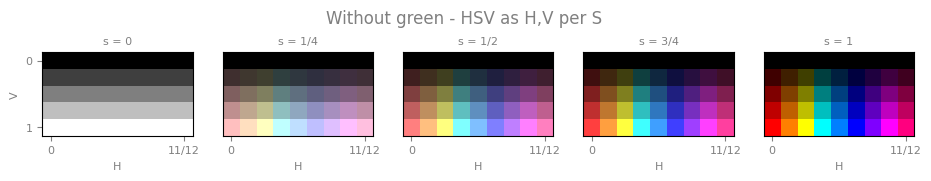

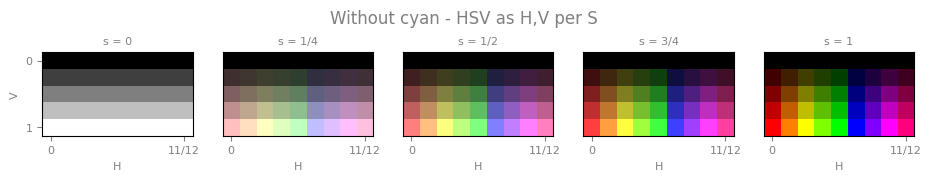

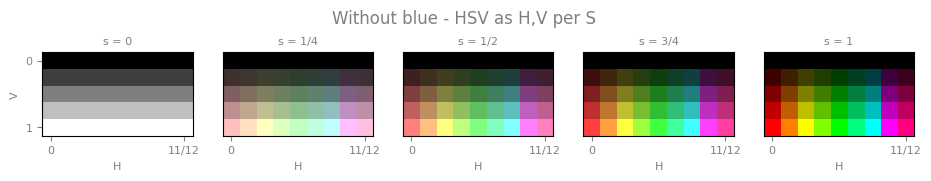

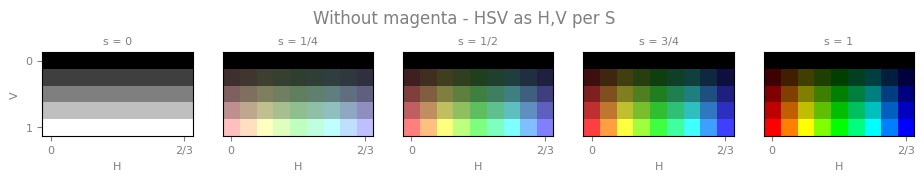

In [35]:
from numpy import floating


def isclose_cyclic(a: int | float | floating | np.ndarray, b: int | float | floating | np.ndarray, atol: float = 1e-8, period = 1.0) -> np.ndarray:
    """Check if two arrays are close in a cyclic manner (e.g., angles)."""
    return np.isclose(a, b, atol=atol) | np.isclose(a + period, b, atol=atol) | np.isclose(a - period, b, atol=atol)

named_colors = [
    ('red', 0/6),
    ('yellow', 1/6),
    ('green', 2/6),
    ('cyan', 3/6),
    ('blue', 4/6),
    ('magenta', 5/6),
]

all_hues = np.arange(0, 1, 1/12)
for name, hue in named_colors:
    # Hold out the hue that is closest to cyan. Use a large tolerance to capture all hues that are close to cyan.
    holdout = isclose_cyclic(all_hues, hue, atol=1/12 + 1e-8)

    hsv_cube = ColorCube.from_hsv(
        all_hues[~holdout],
        np.linspace(0, 1, 5),
        np.linspace(0, 1, 5),
    )

    plot_colors(hsv_cube.permute('svh'), title=f'Without {name}')

Cool, looks good. I think that concludes this prep work. Time to copy the code to a module for use in the experiment.